https://www.kaggle.com/code/frtgnn/introduction-to-pytorch-a-very-gentle-start/notebook

# Data Handling and Processing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [2]:
# Import Data into Pandas DataFrame
df_train = pd.read_csv('data/train.csv')
df_test  = pd.read_csv('data/test.csv')
df_sub   = pd.read_csv('data/gender_submission.csv')

In [3]:
# Training Data
# Deletes the columns ticket and cabin columns in data
df_train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)

# Turns the values in rows into binary 1 and 0 values
sex      = pd.get_dummies(df_train['Sex'],drop_first=True)
embark   = pd.get_dummies(df_train['Embarked'],drop_first=True)

# Merges the datasets to one data frame
df_train = pd.concat([df_train,sex,embark],axis=1)
df_train.drop(['Sex','Embarked'],axis=1,inplace=True)

# Testing Data
df_test.drop( ['Name','Ticket','Cabin'],axis=1,inplace=True)

sex     = pd.get_dummies(df_test['Sex'],drop_first=True)
embark  = pd.get_dummies(df_test['Embarked'],drop_first=True)
df_test = pd.concat([df_test,sex,embark],axis=1)

df_test.drop(['Sex','Embarked'],axis=1,inplace=True)

In [4]:
# Fills the NAN cells of the data with mean values of the data
df_train.fillna(df_train.mean(),inplace=True)
df_test.fillna(df_test.mean(),inplace=True)

# Standardization of the Data
Scaler1 = StandardScaler(); Scaler2 = StandardScaler()

# Takes the top columns of the data (we save these so we can paste these back after standardization)
train_columns = df_train.columns
test_columns  = df_test.columns

# Turns the data frames into standardized data frames 
# The fit_transform() method fits the scaler to the data and then applies the transformation to the data.
# The resulting array is then converted to a dataframe using the pd.DataFrame() function from Pandas.
df_train = pd.DataFrame(Scaler1.fit_transform(df_train))
df_test  = pd.DataFrame(Scaler2.fit_transform(df_test))

# Pasting the columns back
df_train.columns = train_columns
df_test.columns  = test_columns


# Seperates the names of "features and target" and respectively X_train and y_train
# (target = survived, features = column names)

# .iloc acceses the range or group of rows and columns we want to pick, .columns, picks the columns 
# of this data frame and .tolist() converts a pandas data set to python's list of lists
features = df_train.iloc[:,2:].columns.tolist()
# loc works same way but simpler than .iloc, just picks data with "survived" from the data frame with .name
target   = df_train.loc[:, 'Survived'].name


X_train = df_train.iloc[:,2:].values
y_train = df_train.loc[:, 'Survived'].values


# PyTorch

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F # idk same as torch.***
from torch.autograd import Variable

# Activate CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Setting the Neural Network 
# The nn.Dropout layer is a type of regularization layer that is commonly used in deep learning to prevent overfitting.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
model = Net().to(device)

In [7]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [8]:
# Training the Model

"""
The slice y_train[start:end] is often used to select a batch of data for
training or evaluation in machine learning models. For example, a for loop
that iterates over the training data in batches might look like this:
"""

batch_size = 1
n_epochs = 400
batch_no = len(X_train) // batch_size

# To plot the change of loss
losses = []

train_loss = 0
train_loss_min = np.Inf
for epoch in range(n_epochs):
    for i in range(batch_no):
        start = i * batch_size
        end   = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train[start:end]).to(device))
        y_var = Variable(torch.LongTensor(y_train[start:end]).to(device)) 
        
        optimizer.zero_grad()
        output = model(x_var).to(device)
        loss   = criterion(output,y_var)
        losses.append(loss.item()) # appends the loss to the loss matrix
        loss.backward()
        optimizer.step()
        
        values, labels = torch.max(output, 1)
        labels = labels.cpu().numpy()
        num_right   = np.sum(labels.data == y_train[start:end])
        train_loss += loss.item()*batch_size
    
    train_loss = train_loss / len(X_train)
    if train_loss <= train_loss_min:
        print("Validation loss decreased ({:6f} ===> {:6f}). Saving the model...".format(train_loss_min,train_loss))
        torch.save(model.state_dict(), "model.pt")
        train_loss_min = train_loss
    
    if epoch % 200 == 0:
        print('')
        print("Epoch: {} \tTrain Loss: {} \tTrain Accuracy: {}".format(epoch+1, train_loss,num_right / len(y_train[start:end]) ))
print('Training Ended! ')

Validation loss decreased (   inf ===> 0.533342). Saving the model...

Epoch: 1 	Train Loss: 0.5333423055476456 	Train Accuracy: 0.0
Validation loss decreased (0.533342 ===> 0.484693). Saving the model...
Validation loss decreased (0.484693 ===> 0.473104). Saving the model...
Validation loss decreased (0.473104 ===> 0.449347). Saving the model...
Validation loss decreased (0.449347 ===> 0.446306). Saving the model...
Validation loss decreased (0.446306 ===> 0.430330). Saving the model...
Validation loss decreased (0.430330 ===> 0.424016). Saving the model...
Validation loss decreased (0.424016 ===> 0.414211). Saving the model...
Validation loss decreased (0.414211 ===> 0.405469). Saving the model...
Validation loss decreased (0.405469 ===> 0.394652). Saving the model...
Validation loss decreased (0.394652 ===> 0.382878). Saving the model...
Validation loss decreased (0.382878 ===> 0.374203). Saving the model...
Validation loss decreased (0.374203 ===> 0.369331). Saving the model...
Val

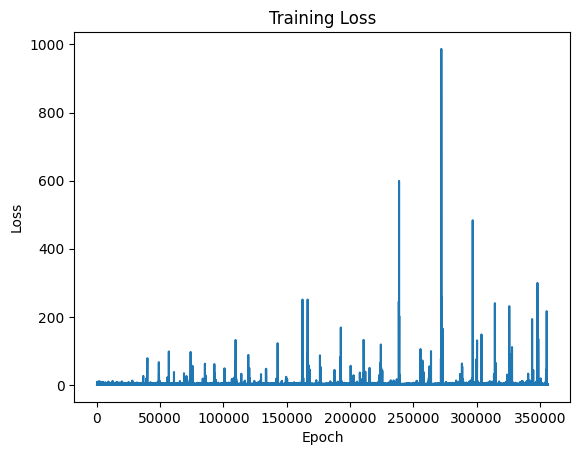

In [9]:
# Plotting the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [10]:
# Predicting using the Testing Array (X_test is turned into X_test_var as a tensor to be used in the model)
X_test     = df_test.iloc[:,1:].values
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=False).to(device)

with torch.no_grad():
    test_result = model(X_test_var).to(device)
values, labels = torch.max(test_result, 1)
labels = labels.cpu().numpy()

# Converts the memoryview to numpy array and panda dataframe to print as .CSV
submission = pd.DataFrame(np.asarray(labels.data))

# Adding row and column labels respectively 
submission = pd.DataFrame({'PassengerId': df_sub['PassengerId'], 'Survived': labels})

submission.to_csv("survived.csv", index=False)

# TORCH.NO.GRAD()

torch.no_grad() is a context manager in PyTorch that sets the requires_grad flag of all tensors in the context to False. This flag determines whether gradients should be calculated for a tensor during the backward pass of a machine learning model's training.

When the requires_grad flag is set to True, gradients are calculated for a tensor and the tensor's gradient accumulator is set to 0. When the requires_grad flag is set to False, gradients are not calculated for the tensor and the tensor's gradient accumulator is not modified.

The torch.no_grad() context manager is often used to disable gradient calculations when evaluating a model's performance on a validation or test set, or when using a model for inference. Disabling gradient calculations can improve the performance of these operations and reduce the memory usage of the model, as it does not need to store the gradients of the tensors in memory.

Here is an example of how to use the torch.no_grad() context manager to evaluate a model's performance on a test set